In [163]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
from scipy.io import loadmat
import time
import threading
import heapq

In [164]:
class Logistic_NC:
    def __init__(self, X, Y, reg):
        self.X = X
        self.Y = Y
        self.μ = reg
        self.d = X.shape[1]
        self.N = X.shape[0]        

    def grad(self, w,gamma=1):
        pred = self.Y * (self.X @ w)
        p = 0.5 * (1 + np.tanh(-0.5 * pred))
        return -self.X.T @ (self.Y * p)/self.N + self.μ *(2*w/gamma**2)/((1/gamma**2+w**2)**2)

    
    def hes(self, w, gamma = 1):
        pred = self.Y * (self.X @ w)
        p = 0.5 * (1 + np.tanh(-0.5 * pred))
        return self.X.T @ (self.X * p * (1-p))/self.N + self.μ * (np.diag(np.reshape((-6*w**4/gamma**2-4*w**2/gamma*4+2/gamma**6)/((1/gamma**2+w**2)**4),-1)))

    def hesT_vec(self, w, U,gamma=1):
            pred = self.Y * (self.X @ w)
            p = 0.5 * (1 + np.tanh(-0.5 * pred))
            return self.X.T@(self.X*p*(1-p)@U)/self.N+self.μ*( (-6*w**4/gamma**2-4*w**2/gamma*4+2/gamma**6)/((1/gamma**2+w**2)**4))*U
    


In [165]:
def GD(oracle, eta, x0, T):
    g=oracle.hesT_vec(x0,oracle.grad(x0))
    res=[np.linalg.norm(g)]
    time_t=[0]
    JV_list = [0]
    JV=0
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        x=x-eta*g
        g=oracle.hesT_vec(x,oracle.grad(x))
        JV=JV+1
        JV_list.append(JV)
        res.append(np.linalg.norm(g))
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list

In [166]:
def LM_1(oracle, M, x0, T):
    J=oracle.hes(x0)
    g=J.T@oracle.grad(x0)
    d=oracle.d
    Id = np.eye(d)
    res=[np.linalg.norm(g)]
    JV_list = [0]
    JV=0
    time_t=[0]
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        update = np.linalg.inv(J.T@J + M*np.linalg.norm(g)**0.5*Id)@g
        x=x-update
        J=oracle.hes(x)
        g=J.T@oracle.grad(x)
        JV = JV+d 
        JV_list.append(JV)
        res.append(np.linalg.norm(g))
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list


In [167]:
def GRLM(oracle, M, m, x0, T):
    F=oracle.grad(x0)
    g=oracle.hesT_vec(x0,F)
    d=oracle.d
    Id = np.eye(d)
    res=[np.linalg.norm(g)]
    JV_list = [0]
    JV=0
    time_t=[0]
    time_start = time.time()
    x=x0.copy()
    for t in range(T):
        if t%m == 0:
            J =oracle.hes(x)
            S,V=np.linalg.eigh(J.T@J)
            invV=V.T
            JV=JV+d
        inner_S= 1/(S+M*np.linalg.norm(g)**0.5)
        update = V@((np.diag(inner_S))@(invV@g))
        x=x-update
        F=oracle.grad(x)
        g=oracle.hesT_vec(x,F)
        JV=JV+1
        JV_list.append(JV)
        g_norm=np.linalg.norm(g)
        res.append(g_norm)
        time_t.append(time.time()-time_start)
    return res, time_t, JV_list      
            

In [168]:
class Data:
    def __init__(self, filename, filetype, size):
        if filetype==1:
            m=loadmat(filename)
            self.X= np.array(m['A']).astype("float")
            self.Y= np.array(m['b']).astype("float")
            self.d = self.X.shape[1]
            n=self.X.shape[0]
            self.p=n//size
            self.n=self.p*size
            self.X=self.X[:self.n,:]
            self.Y=self.Y[:self.n,:]
        
        else:
            Sparse=sklearn.datasets.load_svmlight_file(filename)[0]
            target=sklearn.datasets.load_svmlight_file(filename)[1]
            self.X=Sparse.toarray().astype("float")
            self.Y=target.reshape([np.shape(target)[0],1]).astype("float")
            self.d =self.X.shape[1]
            n=self.X.shape[0]
            self.p=n//size
            self.n=self.p*size
            self.X=self.X[:self.n,:]
            self.Y=self.Y[:self.n,:]

## a1a

In [169]:
filename="a1a.txt"
a1a=Data(filename, 0, 1)
A0=a1a.X
b1=a1a.Y

In [170]:
oracle=Logistic_NC(A0,b1,0.00001)

In [171]:
x0=np.random.randn(oracle.d,1)

In [175]:
res_GRLM_100, time_GRLM_100, JV_GRLM_100 = GRLM(oracle, 1, 50, x0, 8000)
# res_GRLM_1, time_GRLM_1 = GRLM(oracle, 1, 1, x0, 1000)
# res_GRLM_10, time_GRLM_10 = GRLM(oracle, 1, 10, x0, 1000)

In [173]:
res_LM, time_LM,JV_LM = LM_1(oracle, 1, x0, 8000)

In [180]:
res_GD, time_GD,JV_GD= GD(oracle,1,x0,10000)

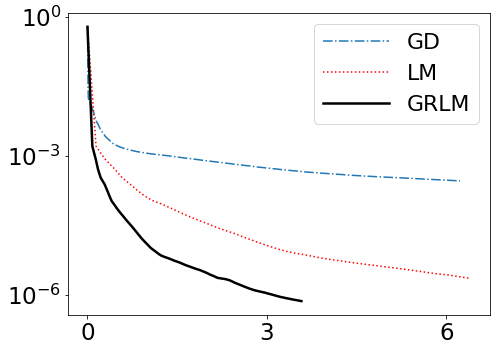

In [178]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD,res_GD,'-.',label='GD') 
plt.plot(time_LM[:2500:50],res_LM[:2500:50],':r',label='LM')
plt.plot(time_GRLM_100[:4000:50],res_GRLM_100[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,3,6])
plt.yticks([1e-6,1e-3,1e0])
plt.tight_layout()
plt.savefig('fig/NC_a1a_time.png')
plt.savefig('fig/NC_a1a_time.pdf',format='pdf')

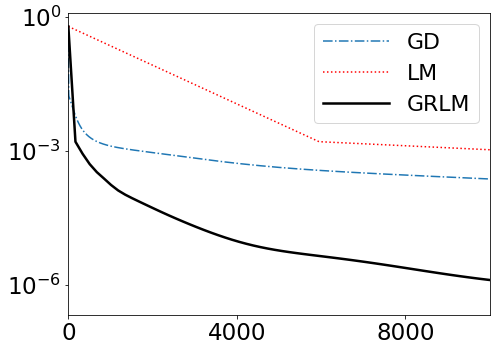

In [182]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD,res_GD,'-.',label='GD') 
plt.plot(JV_LM[:7000:50],res_LM[:7000:50],':r',label='LM')
plt.plot(JV_GRLM_100[:4000:50],res_GRLM_100[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,4000,8000])
plt.xlim(0,10000)
plt.yticks([1e-6,1e-3,1e0])
plt.tight_layout()
plt.savefig('fig/NC_a1a_JV.png')
plt.savefig('fig/NC_a1a_JV.pdf',format='pdf')

## w1a

In [183]:
filename="w1a.txt"
a1a=Data(filename, 0, 1)
A0=a1a.X
b1=a1a.Y

In [184]:
oracle=Logistic_NC(A0,b1,0.00001)

In [185]:
x0=np.random.randn(oracle.d,1)

In [186]:
res_LM, time_LM,JV_LM = LM_1(oracle, 1, x0, 8000)

In [187]:
res_GD, time_GD,JV_GD= GD(oracle,1,x0,40000)

In [188]:
res_GRLM_100, time_GRLM_100, JV_GRLM_100 = GRLM(oracle, 2, 100, x0, 16000)

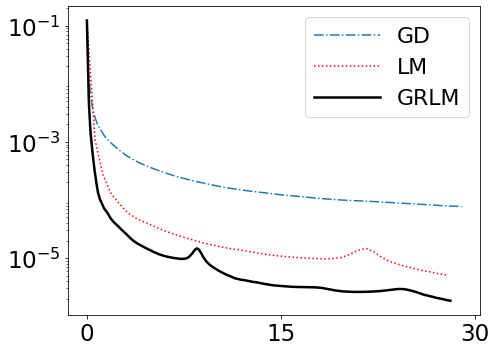

In [195]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD[:13000],res_GD[:13000],'-.',label='GD') 
plt.plot(time_LM[:2200:50],res_LM[:2200:50],':r',label='LM')
plt.plot(time_GRLM_100[:10000:50],res_GRLM_100[:10000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,15,30])
plt.yticks([1e-5,1e-3,1e-1])
plt.tight_layout()
plt.savefig('fig/NC_w1a_time.png')
plt.savefig('fig/NC_w1a_time.pdf',format='pdf')

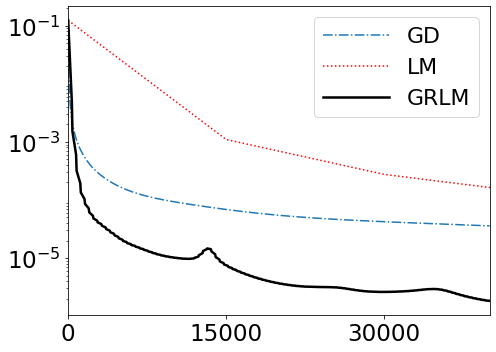

In [206]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD[:40000],res_GD[:40000],'-.',label='GD') 
plt.plot(JV_LM[:200:50],res_LM[:200:50],':r',label='LM')
plt.plot(JV_GRLM_100[:10000:50],res_GRLM_100[:10000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,15000,30000])
plt.xlim(0,40000)
plt.yticks([1e-5,1e-3,1e-1])
plt.tight_layout()
plt.savefig('fig/NC_w1a_JV.png')
plt.savefig('fig/NC_w1a_JV.pdf',format='pdf')

### SPlice

In [207]:
filename="splice.txt"
a1a=Data(filename, 0, 1)
A0=a1a.X
b1=a1a.Y

In [208]:
oracle=Logistic_NC(A0,b1,0.00001)

In [209]:
x0=np.random.randn(oracle.d,1)

In [210]:
res_LM, time_LM,JV_LM = LM_1(oracle, 1, x0, 8000)

In [211]:
res_GD, time_GD,JV_GD= GD(oracle,1,x0,8000)

In [212]:
res_GRLM_100, time_GRLM_100, JV_GRLM_100 = GRLM(oracle, 1, 100, x0, 8000)

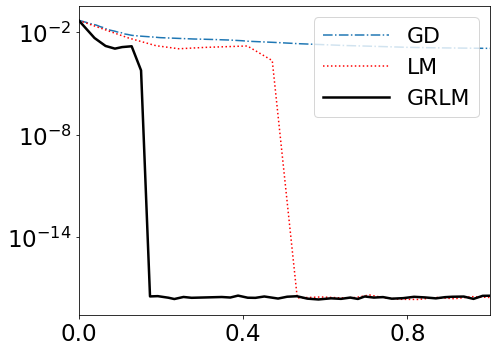

In [158]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(time_GD,res_GD,'-.',label='GD') 
plt.plot(time_LM[:3000:50],res_LM[:3000:50],':r',label='LM')
plt.plot(time_GRLM_100[:4000:50],res_GRLM_100[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,0.4,.8])
plt.xlim(0,1)
plt.yticks([1e-14,1e-8,1e-2])
plt.tight_layout()
plt.savefig('fig/NC_splice_time.png')
plt.savefig('fig/NC_splice_time.pdf',format='pdf')

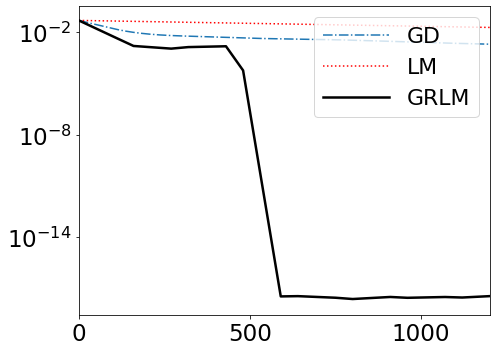

In [162]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3}
plt.rcParams.update(params)
plt.plot(JV_GD,res_GD,'-.',label='GD') 
plt.plot(JV_LM[:1000:50],res_LM[:1000:50],':r',label='LM')
plt.plot(JV_GRLM_100[:4000:50],res_GRLM_100[:4000:50],'-k',linewidth=2.5, label='GRLM')
plt.tick_params(labelsize=23)
plt.legend(loc="upper right")
plt.yscale('log')
plt.xticks([0,500,1000])
plt.xlim(0,1200)
plt.yticks([1e-14,1e-8,1e-2])
plt.tight_layout()
plt.savefig('fig/NC_splice_JV.png')
plt.savefig('fig/NC_splice_JV.pdf',format='pdf')